### 1. import libraries and prepare dataset

In [ ]:
import sklearn
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import pandas as pd

In [ ]:
# request content and overwrite file
from google.colab import drive
drive.mount('/content/drive')

import requests
from pathlib import Path

PATH = '/content/drive/MyDrive/pytorch/helper_functions.py'
if Path(PATH).is_file():
    print('helper_functions.py exists, skip download')
else:
    print('download helper_functions.py')
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    f = open(PATH, 'x')
    f.close()
    with open(PATH, 'wb') as f:
        f.write(request.content)

Mounted at /content/drive
helper_functions.py exists, skip download


In [ ]:
# add folder to path and import the file
# a custom file function is used

import sys
sys.path.insert(0, '/content/drive/MyDrive/pytorch/')
import helper_functions
from helper_functions import plot_decision_boundary

In [ ]:
n_samples = 1000

X, y = make_circles(n_samples = n_samples, noise = .03, random_state = 42)

circles = pd.DataFrame({'X1': X[:, 0],
                        'X2': X[:, 1],
                        'labels': y})
circles.head()

,X1,X2,labels
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


[]

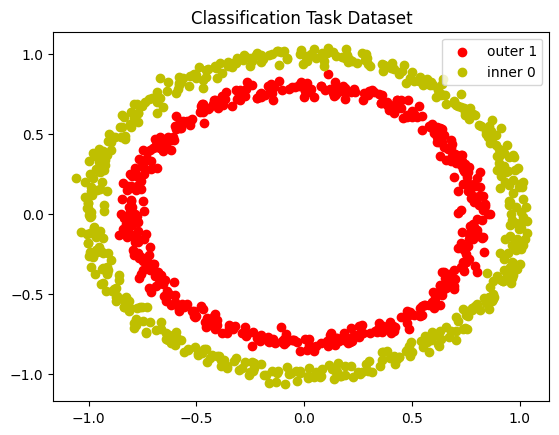

In [ ]:
plt.scatter(x = circles[circles.labels == 1].iloc[:, 0],
            y = circles[circles.labels == 1].iloc[:, 1],
            c = 'r',
            label = 'outer 1')

plt.scatter(x = circles[circles.labels == 0].iloc[:, 0],
            y = circles[circles.labels == 0].iloc[:, 1],
            c = 'y',
            label = 'inner 0')

plt.title('Classification Task Dataset')

plt.legend(loc = 'upper right')
plt.plot()

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
X = torch.from_numpy(X)
y = torch.from_numpy(y).unsqueeze(dim = 1)

X = X.type(torch.float32)
y = y.type(torch.float32)
X.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2,
                                                    random_state = 42)

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### 2. define model, loss function, optimizer, and final metric

In [ ]:
class NN_CircleModel_v0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features = 2, out_features = 8)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(in_features = 8, out_features = 4)
        self.sigmoid = nn.Sigmoid()
        self.output = nn.Linear(in_features = 4, out_features = 1)

        # alternative:
        # self.layers = nn.Sequential(
        #     nn.Linear(2, 5),
        #     nn.ReLU(),
        #     nn.Linear(5, 1),
        #     nn.Sigmoid())

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        res = self.layer1(X)
        res = self.relu(res)
        res = self.layer2(res)
        res = self.relu(res)
        res = self.output(res)
        return res
        # alternative:
        # return self.layers(X)

model_0 = NN_CircleModel_v0().to(device)
model_0 = torch.compile(model_0)
model_0.state_dict()

OrderedDict([('_orig_mod.layer1.weight',
              tensor([[ 0.0132,  0.4235],
                      [-0.5805,  0.6457],
                      [-0.4398, -0.5778],
                      [-0.0971,  0.1751],
                      [ 0.3843, -0.6163],
                      [ 0.4007, -0.5215],
                      [-0.0300,  0.3863],
                      [-0.0205, -0.3249]])),
             ('_orig_mod.layer1.bias',
              tensor([-0.4899, -0.0534,  0.2897, -0.3701,  0.2790,  0.0453,  0.4018, -0.5416])),
             ('_orig_mod.layer2.weight',
              tensor([[-0.0546,  0.3282, -0.2541, -0.1762, -0.0651, -0.3039,  0.2277,  0.0519],
                      [ 0.1483,  0.1967,  0.3278,  0.3280,  0.0369,  0.3151, -0.0658, -0.2486],
                      [ 0.2944,  0.1260,  0.0392,  0.1605, -0.1227,  0.0703,  0.2665,  0.1566],
                      [ 0.3208,  0.2934, -0.1673,  0.0923, -0.1379,  0.0032,  0.1352, -0.2088]])),
             ('_orig_mod.layer2.bias',
              ten

In [ ]:
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))

print(len(untrained_preds))
print('first five predictions: \n', untrained_preds[:5])

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


200
first five predictions: 
 tensor([[0.4101],
        [0.4070],
        [0.4484],
        [0.4012],
        [0.4725]])


In [ ]:
loss_fn = nn.BCEWithLogitLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(),
                             lr = .01)

In [ ]:
def accuracy_score(y_pred, y_true, threshold = .5):
    correct = torch.eq(torch.sigmoid(y_pred) >= threshold, y_true)
    return correct.sum().item() / len(y_pred) * 100

In [ ]:
# currently only 50% correct
accuracy_score(untrained_preds, y_test.to(device))

50.0

### 3. Train Model

In [ ]:
epochs = 1000
t = []
train_loss = []
eval_loss = []

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    model_0.train()
    y_train_pred = model_0(X_train)
    loss1 = loss_fn(y_train_pred, y_train)
    optimizer.zero_grad()
    loss1.backward()
    optimizer.step()

    if epoch % 50 == 0:
        model_0.eval()
        with torch.inference_mode():
            y_eval_pred = model_0(X_test)
            loss2 = loss_fn(y_eval_pred, y_test)
        print(f'epoch {epoch}: train_loss = {loss1} | test_loss = {loss2}')
        # accuracy_score takes y_train_pred to logit
        print(f'train accuracy: {accuracy_score(y_train_pred, y_train)}')
        print(f'eval accuracy: {accuracy_score(y_eval_pred, y_test)}')
        t.append(epoch)
        train_loss.append(loss1)
        eval_loss.append(loss2)

epoch 0: train_loss = 0.7030712366104126 | test_loss = 0.6973263025283813
train accuracy: 50.0
eval accuracy: 50.0
epoch 50: train_loss = 0.66621994972229 | test_loss = 0.6647346615791321
train accuracy: 57.125
eval accuracy: 60.0
epoch 100: train_loss = 0.38541167974472046 | test_loss = 0.3906046748161316
train accuracy: 97.875
eval accuracy: 97.0
epoch 150: train_loss = 0.08699286729097366 | test_loss = 0.12164108455181122
train accuracy: 99.5
eval accuracy: 98.0
epoch 200: train_loss = 0.0349201038479805 | test_loss = 0.06552997976541519
train accuracy: 99.875
eval accuracy: 99.0
epoch 250: train_loss = 0.019639018923044205 | test_loss = 0.04585053399205208
train accuracy: 100.0
eval accuracy: 99.0
epoch 300: train_loss = 0.013107618317008018 | test_loss = 0.03710364177823067
train accuracy: 100.0
eval accuracy: 99.0
epoch 350: train_loss = 0.009513147175312042 | test_loss = 0.03182920441031456
train accuracy: 100.0
eval accuracy: 99.0
epoch 400: train_loss = 0.007296712603420019 | 

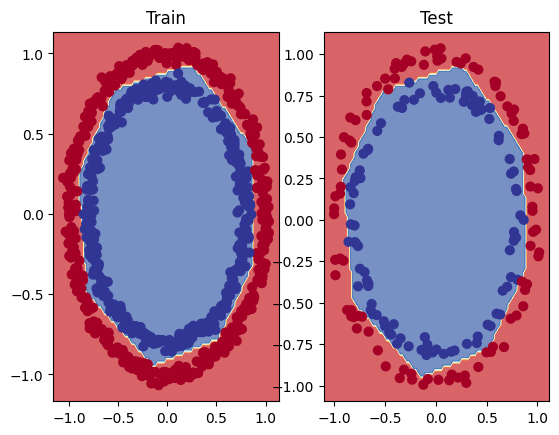

In [ ]:
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)

### 4. evaluate

In [ ]:
print('accuracy score of the model(%):', accuracy_score(model_0(X_test), y_test))

accuracy score of the model(%): 99.5
